In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class Neural_Network():
    def __init__(self, input_shape, hidden_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_shape = hidden_shape
        self.n_layers = len(hidden_shape) + 2
        
        self.w_list = self.Compile(input_shape, hidden_shape, output_shape)
        self.cost_list = []
        
    #### High Level Funcitons ####
    '''
    
    def fit(self,X,Y, alpha=0.001, epochs = 10, batch_size = 10):
        
        for epo in range(epochs):
            
            for instance in zip(X,Y):
                x = instance[0]
                y = instance[1]
                all_layers_info = self.feedforward(self.w_list, x)
                all_layers_delta = self.all_layers_delta_calculator(all_layers_info, y, self.n_layers)
                all_layres_Grad = self.all_layers_E_Grad(self.n_layers, all_layers_delta, all_layers_info)
                self.w_list = self.update_w_list(self.w_list, all_layers_Grad, alpha)
            
            self.cost_list.append(self.cost(self.predict([x]), y))
            
    '''
    
    def fit(self,X,Y, alpha=0.001, epochs = 10, batch_size = 10):
        for epo in range(epochs):
            
            i=0
            while ((i+1)*batch_size<=len(X)):

                X_B = X[(i)*batch_size:(i+1)*batch_size]
                Y_B = Y[(i)*batch_size:(i+1)*batch_size]
                all_layers_delta_sum = 0

                for instance in zip(X_B,Y_B):
                    x = instance[0]
                    y = instance[1]
                    all_layers_info = self.feedforward(self.w_list, x)
                    all_layers_delta = self.all_layers_delta_calculator(all_layers_info, y, self.n_layers, self.w_list)
                    all_layers_delta_sum += np.array(all_layers_delta)

                all_layers_delta_sum /= batch_size
                all_layers_Grad = self.all_layers_E_Grad(x, self.n_layers, all_layers_delta, all_layers_info)
                self.w_list = self.update_w_list(self.w_list, all_layers_Grad, alpha)
    
                i+=1
        
                self.cost_list.append(self.cost(self.predict([x]), y))

                
        
            
        
    
    def predict(self, X):
        predict_list = []
        for elem in X:
            x = elem
            result = self.feedforward(self.w_list, x)[-1]
            predict_list.append(result)
        
        return np.array(predict_list)
        
        
    #### Low Level Functions ####
    
    def cost(self, predict, y):
        return 0.5*np.sum((predict - y)**2)
    
    def feedforward(self,w_list, x):
        pre_activated = x
        raw_list = []
        activated_list = []
        for w in w_list[:-1]:
            current_raw = self.WxX(w,pre_activated)
            current_activated = self.sig(current_raw)

            raw_list.append(current_raw)
            activated_list.append(current_activated)

            pre_activated = current_activated

        predict_raw = self.WxX(w_list[-1], activated_list[-1])
        predict_activated = self.output_layer_activator(predict_raw)

        raw_list.append(predict_raw)
        activated_list.append(predict_activated)

        return raw_list, activated_list, predict_raw
    
    
    def Compile(self, input_shape, hidden_shape, output_shape):
        w_shapes = self.w_shaper(input_shape, hidden_shape, output_shape)
        w_list = self.init_w_list(w_shapes)
        return w_list
    
    def init_w_list(self,w_shapes):
        w_list = []
        for w in w_shapes:
            w_list.append(np.random.random((w[0], w[1]+1)))
        return w_list
    
    
    def w_shaper(self, input_shape, hidden_shape, output_shape):
        all_shapes = [input_shape] + hidden_shape + [output_shape]
        w_shapes = []
        for elem in zip(all_shapes[1:], all_shapes[:-1]):
            w_shapes.append(elem)
        return w_shapes
    
    def WxX(self, w,x):
        result = w @ self.one_adder(x).reshape((-1,1))
        result = result.reshape(-1)
        return result
    
    def one_adder(self, x):
        return np.array([1] + x.tolist())
        
    def sig(self, x):
        return 1/(1 + np.exp(-x))
    
    def output_layer_activator(self, x):
        return x
    
    def d_sig(self,x):
        return self.sig(x) * (1-self.sig(x))
    
    #### Delta #####
    
    def output_layer_delta(self, all_layers_info,y):
        
        delta = (all_layers_info[-1] - y) * self.output_layer_activation_der(all_layers_info[0][-1]) 
        return delta
    
    def output_layer_activation_der(self, x):
        return 1
    
    def Wxdelta(self, w, delta):
        result = np.delete(w,0,axis=1).T @ delta.reshape((-1,1)) 
        return result.reshape(-1)
    
    def delta_calculator(self, layer,delta_list, w_list, all_layers_info):
        result = self.Wxdelta(w_list[layer+1], delta_list[layer+1])
        result = result.reshape((-1,1)) * self.d_sig(all_layers_info[0][layer]).reshape((-1,1))
        return result
    
    def all_layers_delta_calculator(self, all_layers_info, y, n_layers, w_list):
        
        delta_list = [i for i in range(n_layers-1)]
        next_layer_delta = self.output_layer_delta(all_layers_info, y)
        delta_list[-1] = next_layer_delta

        for i in range(n_layers-3,-1,-1): # 3,2,1,0
            current_delta = self.delta_calculator(i, delta_list, w_list,all_layers_info)
            delta_list[i] = current_delta.reshape(-1)

        return delta_list
    
    def Grad_E_layer(self, layer,x , all_layers_delta, all_layers_info):
        if layer > 0:
            return all_layers_delta[layer].reshape((-1,1)) @ self.one_adder(all_layers_info[1][layer-1]).reshape((1,-1))

        else:
            return all_layers_delta[layer].reshape((-1,1)) @ self.one_adder(x).reshape((1,-1))

        
    def all_layers_E_Grad(self, x,n_layers, all_layers_delta, all_layers_info):
        Grad_E_list = []
        for i in range(n_layers-1): # 0,1,2,3,4  n_layers = 6
            Grad_E_list.append(self.Grad_E_layer(i,x,all_layers_delta, all_layers_info))

        return Grad_E_list
    
    def update_w_list(self, w_list, all_layers_Grad, alpha=0.001):
        new = np.array(w_list) - alpha * np.array(all_layers_Grad)
        return new
    

## Test on a Simple Dataset

In [10]:
input_shape = 5
hidden_shape = [4,2,4,3]
output_shape = 2


In [11]:
X = np.array([[3,2,4,1,2],[1,2,3,4,1],[5,4,4,3,1],[4,5,6,3,1],[-1,4,0,4,1]])
Y = np.array([[4,0],[4,1],[5,1],[6,1],[-1,1]])

In [12]:
model = Neural_Network(input_shape, hidden_shape, output_shape)

In [17]:
model.fit(X,Y,epochs=1000, batch_size=3, alpha=0.0002)


Text(0.5, 0, 'Epochs')

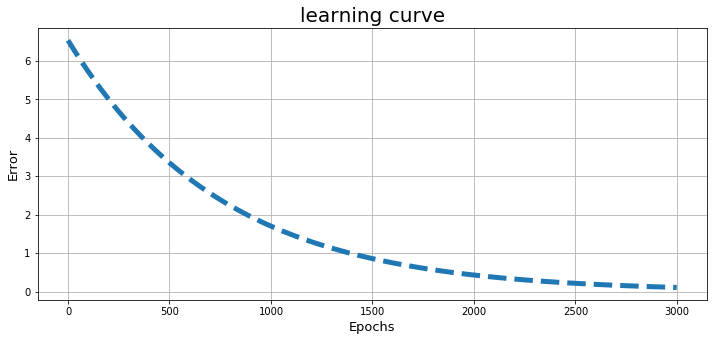

In [19]:
plt.figure(figsize=(12,5))
plt.plot(model.cost_list,'--',lw=5,)
plt.grid('on')
plt.title('learning curve',size=20)
plt.ylabel('Error',size=13)
plt.xlabel('Epochs',size=13)

In [608]:
p=0
while(p<1):
    print('hey')
    p += 1

hey
